## QBUS3850 Lab 3 – AR Models

The AutoRegressive Integrated Moving Average (ARIMA) model, which consist 3 major components:
- The AR part of ARIMA indicates that the evolving variable of interest 𝑦' is regressed on its own lagged (i.e., prior $y_{t-1:t-p}$) values.
- The MA part indicates that the error is actually a linear combination of error terms $\epsilon_{t-1:t-q}$ whose values occurred contemporaneously and at various times in the past.
- The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once) so that the ARIMA could handle the non-stationary data. (Note that the AR, MA and ARMA model are still require a weakly stationary data as input)

The purpose of each of these features is to make the model fit the data as well as possible. 

In this week, we mainly focus on the implementation of AR model. Mathematically, an AR model of order $p$ is defined as:

$$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \phi_{3}y_{t-3} \dots \phi_{p}y_{t-p} + \epsilon_{t}$$

$$ y_{t} = c + \sum_{i = 1}^{p} \phi_{i}y_{t-i} + \epsilon_{t}$$

where c is a constant value, $\phi_{1} \dots \phi_{p}$ are the parameters for the model, and $\epsilon_{t}$ is white noise.

This can be equivalent to the backshift representation with the operator $B$ as:

$$ y_{t} = c + \sum_{i = 1}^{p} \phi_{i}L^{i}y_{t} + \epsilon_{t}$$

So that moving the summation term to the left side and using polynomial notation, we have:

$$ \epsilon_{t} = y_{t} - \sum_{i = 1}^{p} \phi_{i}L^{i}y_{t} - c$$

$$ \epsilon_{t} = (1 - \sum_{i = 1}^{p} \phi_{i}L^{i})(y_{t} - \mu)$$

Where $\mu = c/(1 − \sum_j \phi_{j})$.

An AR model can thus be viewed as the output of a filter which input is white noise.

However, for an AR(p) model, some parameter constraints are necessary for the model to ensure weakly stationary. More specifically, processes in the AR(1) model with only $| \phi_{1} < 1 |$ could be viewed as __weakly stationary__.

__Question__: Check whether the process $Y_t=0.3Y_{t-1}+0.04Y_{t-2}+\epsilon_t$ is stationary?

- Solution: Solve the polynomial $1-0.3L-0.04L^2=0$ for $L$ as if $L$ were a number. By the quadratic formula the roots are

$$\begin{aligned}\frac{0.3\pm\sqrt{0.3^2+4\times 0.04\times1}}{2\times 0.04}\\\frac{0.3\pm\sqrt{0.25}}{0.08}\\\frac{0.3\pm 0.5}{0.08}\end{aligned}$$

The roots are 10 and -2.5. Both lie outside the unit circle.

For AR(2) model it can be shown that stationarity holds under the following constraints in general:

$$|\phi_{2}| < 1, \phi_{1} + \phi_{2} < 1 \text{ and } \phi_{1} - \phi_{2} < 1$$


Selecting a suitable order value p can be tricky. We need to observe the PACF curve to find out the cutting off value as the order for our AR model. The partial autocorrelation of an AR(p) process equates zero at lag which is
bigger than order of p and provide a good model for the correlation in $y_{1:p+1}$, so the appropriate maximum lag is the one beyond which the partial autocorrelations are all zero.

In [1]:
import matplotlib.pyplot as plt
import statsmodels as sm 
import statsmodels.api as smt
import numpy as np
import pandas as pd


## 1. AR(1) Process

Text(0.5, 1.0, 'Autoregressive (AR) Model')

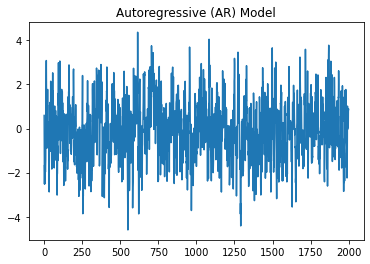

In [2]:
# Setting up the random generator 
np.random.seed(0x123abc)

# Y_t = 0.7 * Y_{t-1} + e_t          
arparams = np.array([0.7])
zero_lag = np.array([1])

ar = np.r_[1, -arparams]  # add zero-lag (coefficient 1) and negate
c = 0
sigma2 = 1
  
y = sm.tsa.arima_process.arma_generate_sample(ar = ar, ma = zero_lag, nsample = 2000)

plt.figure()
plt.plot(y)
plt.title("Autoregressive (AR) Model")

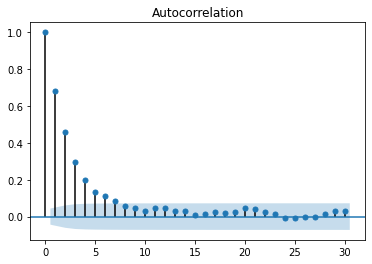

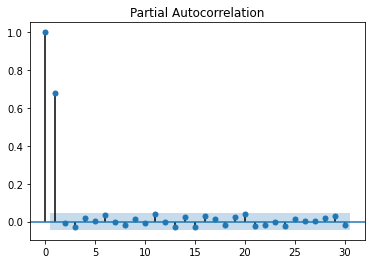

In [3]:
# Examine the ACF and PACF plots

## The ACF dies off exponentially.
smt.graphics.tsa.plot_acf(y, lags=30, alpha = 0.05)

# Because this is an AR model of lag 1, the PACF dies out after lag 1
smt.graphics.tsa.plot_pacf(y, lags=30, alpha = 0.05)
print()

(0.0, 30.0)

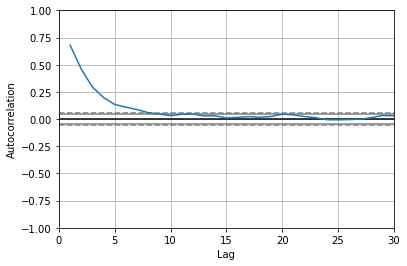

In [4]:
# Pandas can also produce ACF (but not PACF)
from pandas.plotting import autocorrelation_plot

plt.figure()
plot1 = autocorrelation_plot(y)
plot1.set_xlim([0, 30])


In [5]:
# Calculate Mean 
# Since c = 0 then this result will be 0 anyway
y_uncond_mean = c / (1 - arparams[0])
print(y_uncond_mean)

diff_y = pd.Series.diff(pd.Series(y)).dropna()

sample_mean = np.mean(y)
print(sample_mean)

0.0
-0.051483378756977075


In [6]:
# Calculate Variance
# arma_generate_sample uses np.random.randn to generate epsilon
# We know then that by default 
# var(epsilon) = 1 (or sigma^2 = 1)
# mean(epsilon) = 0

y_uncond_var = sigma2 / (1 - np.power(arparams[0],2))
print(y_uncond_var)

sample_var = np.var(y)
print(sample_var)


1.9607843137254901
1.7951586619807292


## 2. Fit AR(1) to synthesized data

Now let’s try and fit a model to these samples and compare the parameters.

In [7]:
## y was generated from the process Y_t = 0.7 * Y_{t-1} + e_t  
fit1 = sm.tsa.arima_model.ARMA(y, (1,0)).fit(trend='nc')
print( fit1.summary() )

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(1, 0)   Log Likelihood               -2802.086
Method:                       css-mle   S.D. of innovations              0.982
Date:                Fri, 13 Mar 2020   AIC                           5608.172
Time:                        09:05:03   BIC                           5619.373
Sample:                             0   HQIC                          5612.285
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.6806      0.016     41.574      0.000       0.648       0.713
                                    Roots                                    
                  Real          Imaginary           M

#### Question:
 - What does trend='nc' mean?
 - Can you interpret the result of trend='c'?

Specifying `trend='nc'` implies there is no constant in the model. For models without differencing this implies that the (unconditional mean) is zero. If the data have been differenced, then specifying a constant in the ARMA model implies a deterministic trend in the original data.

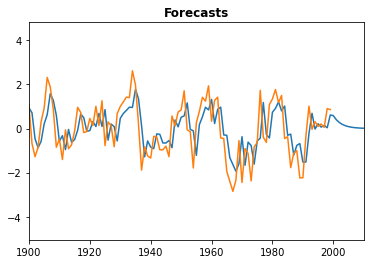

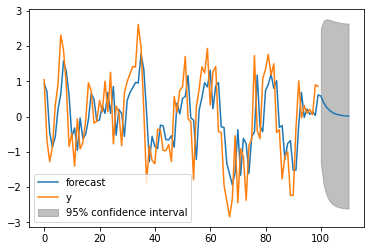

In [8]:
forecast = fit1.predict( start=0, end=len(y) + 10 )

## Plot actual vs fitted + forecasts.
plt.figure()
plt.plot( forecast )
plt.plot(y)
plt.title('Forecasts', weight = 'bold')
plt.xlim(len(y)-100,len(y)+10)
plt.show()

# Quick plot actual vs fitted + forecasts with 95% confidence intervals. 
fit1.plot_predict( start=len(y)-100, end=len(y)+10, alpha=0.05 )
print()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2000
Model:                     ARMA(1, 0)   Log Likelihood               -2801.822
Method:                       css-mle   S.D. of innovations              0.982
Date:                Fri, 13 Mar 2020   AIC                           5609.644
Time:                        09:05:03   BIC                           5626.447
Sample:                             0   HQIC                          5615.814
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0498      0.069     -0.727      0.467      -0.184       0.085
ar.L1.y        0.6801      0.016     41.520      0.000       0.648       0.712
                                    Roots           

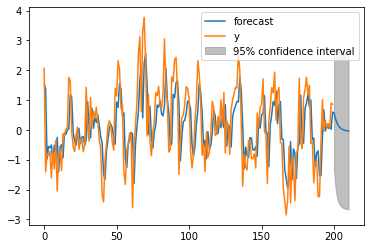

In [9]:
p,q = 1,0

from statsmodels.tsa.arima_model import ARIMA
model_AIC = ARIMA( y, order=(p, 0, q) )  
results_AIC_ARIMA = model_AIC.fit()   
print( results_AIC_ARIMA.summary() )

results_AIC_ARIMA.plot_predict( start=len(y)-200, end=len(y)+10, alpha=0.05 )
print()

## 3. Fit AR(p) to real data

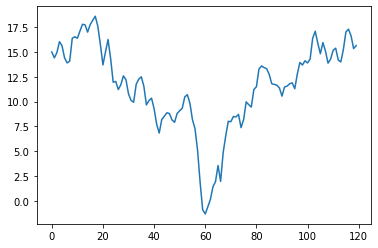

In [10]:
data = pd.read_csv('data.csv')
data = data['Data']

#data = pd.read_csv('AirPassengers.csv')
#data = np.log( data['Passengers'] )

plt.figure()
plt.plot(data)

nan


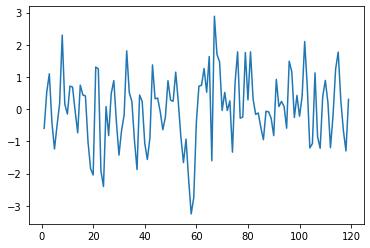

In [11]:
# We calculate difference series, data[1]-data[0], data[2]-data[1],...
diff_data = pd.Series.diff(data)
# Checking the first entry in diff_data. Why is it a nan? What should we do about it?
print( diff_data.iloc[0] )
diff_data = diff_data.dropna()

# Plot the differenced data
plt.figure()
plt.plot(diff_data)


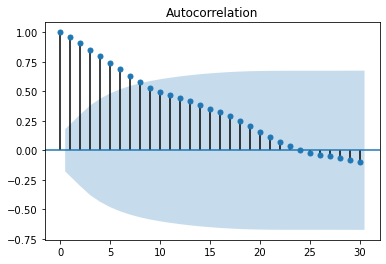

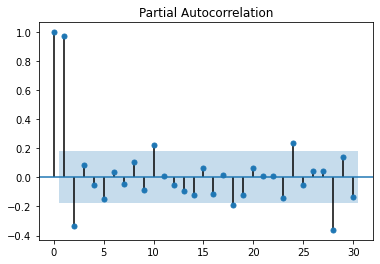

In [12]:
# Plot the ACF/PACF for the data.
smt.graphics.tsa.plot_acf( data, lags=30, alpha=0.05 )
smt.graphics.tsa.plot_pacf( data, lags=30, alpha=0.05 )

# lags = 30 means drawing 30 lags
# Here alpha=.05, 95% confidence intervals are returned 
# where the standard deviation is computed according to 
# Bartlett’s formula.

# You may change 0.05 to other values for alpha to see what will happen
print()

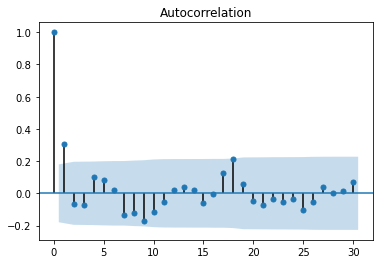

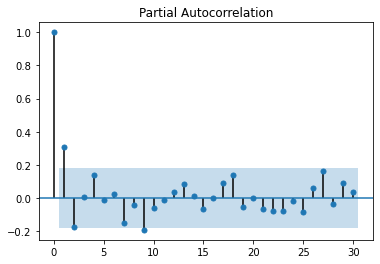

In [13]:
# For differenced time series
smt.graphics.tsa.plot_acf(diff_data, lags=30, alpha=0.05)
smt.graphics.tsa.plot_pacf(diff_data, lags=30, alpha = 0.05)
print()

#### Questions:
 - What order AR model is appropriate?
 - Fit an AR model to the differenced data.
 - Plot the differenced data against the AR model predictions.
 - Plot the original data against the AR model predictions.
 - Re-do these questions with Air Passenger data.

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


                              ARMA Model Results                              
Dep. Variable:                   Data   No. Observations:                  119
Model:                     ARMA(1, 0)   Log Likelihood                -174.284
Method:                       css-mle   S.D. of innovations              1.046
Date:                Fri, 13 Mar 2020   AIC                            352.569
Time:                        09:05:05   BIC                            358.127
Sample:                             0   HQIC                           354.826
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Data     0.3051      0.087      3.509      0.000       0.135       0.475
                                    Roots                                    
                  Real          Imaginary           M

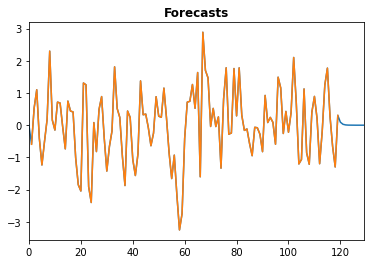

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


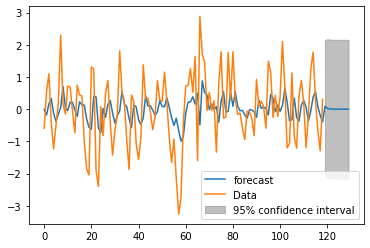

In [14]:
fit2 = sm.tsa.arima_model.ARMA( diff_data, order=(1,0) ).fit( trend='nc' )
print( fit2.summary() )

forecast = fit2.predict(start=0, end=len(diff_data)+10)

plt.figure()
plt.plot( forecast / fit2.params[0] )
plt.plot( diff_data )
plt.title('Forecasts', weight = 'bold')
plt.xlim( 0, len( diff_data ) + 10 )
plt.show()

fit2.plot_predict( start=0, end=len(diff_data)+10, alpha=0.05 )
print()

c:\program files\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


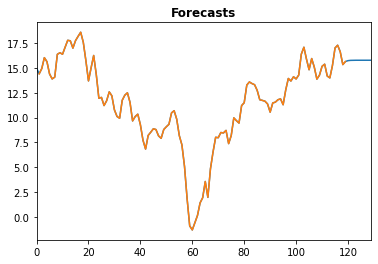

In [17]:
forecast = fit2.predict(start=0, end=len(diff_data) + 10 )

plt.figure()
plt.plot( data[0] + np.cumsum( forecast )  / fit2.params[0] )
plt.plot( data[0] + np.cumsum( diff_data ) )
plt.title('Forecasts', weight = 'bold')
plt.xlim( 0, len(diff_data) + 10 )
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                 D.Data   No. Observations:                  119
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -174.284
Method:                       css-mle   S.D. of innovations              1.046
Date:                Fri, 13 Mar 2020   AIC                            354.568
Time:                        09:05:06   BIC                            362.905
Sample:                             1   HQIC                           357.953
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0043      0.138      0.031      0.975      -0.265       0.274
ar.L1.D.Data     0.3050      0.087      3.509      0.000       0.135       0.475
                                    Roots   

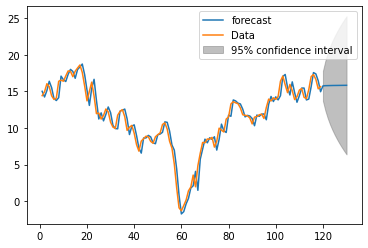

In [16]:
p,q = 1,0

from statsmodels.tsa.arima_model import ARIMA
model_AIC = ARIMA( data, order=(p, 1, q) )  
results_AIC_ARIMA = model_AIC.fit( disp=-1 )   
print( results_AIC_ARIMA.summary() )

results_AIC_ARIMA.plot_predict( start=1, end=len(data)+10, alpha=0.05 )
print()